**FALLS LAKE SIMULATION PROJECT BY PETER WASSWA**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10,4)

url = 'https://raw.githubusercontent.com/waswapeter/Falls_Lake/main/FLR-daily_flows.csv'

inflow = pd.read_csv(url, on_bad_lines='skip', sep=',')  # or sep=';' if the delimiter is semicolon

#Generate date array from October 01, 2010, to September 30, 2022
date_range = pd.date_range(start='2010-10-01', end='2022-09-30', freq='D')


0
47070


In [6]:
# Assuming 'inflow' is your DataFrame and 'date_range' is your DatetimeIndex
inflow_cfs_series = pd.Series(inflow['inflow_cfs'].values, index=date_range)
inflow_monthly = inflow_cfs_series.resample('ME').sum()
inflow_monthly.name = 'inflow_cfs_monthly'
max_value = inflow_monthly.max()
min_value = inflow_monthly.min()
print(min_value)
print(max_value)

2352
99642


**Generate a release policy figure**, Assumptions:a)For values of storage lower than Theta_1, only the Minimum Environmental Flow (MEF) is released.
b)For values higher than Theta_2, dam spillways are opened to release Excess. c) Evaporation is assumed null.

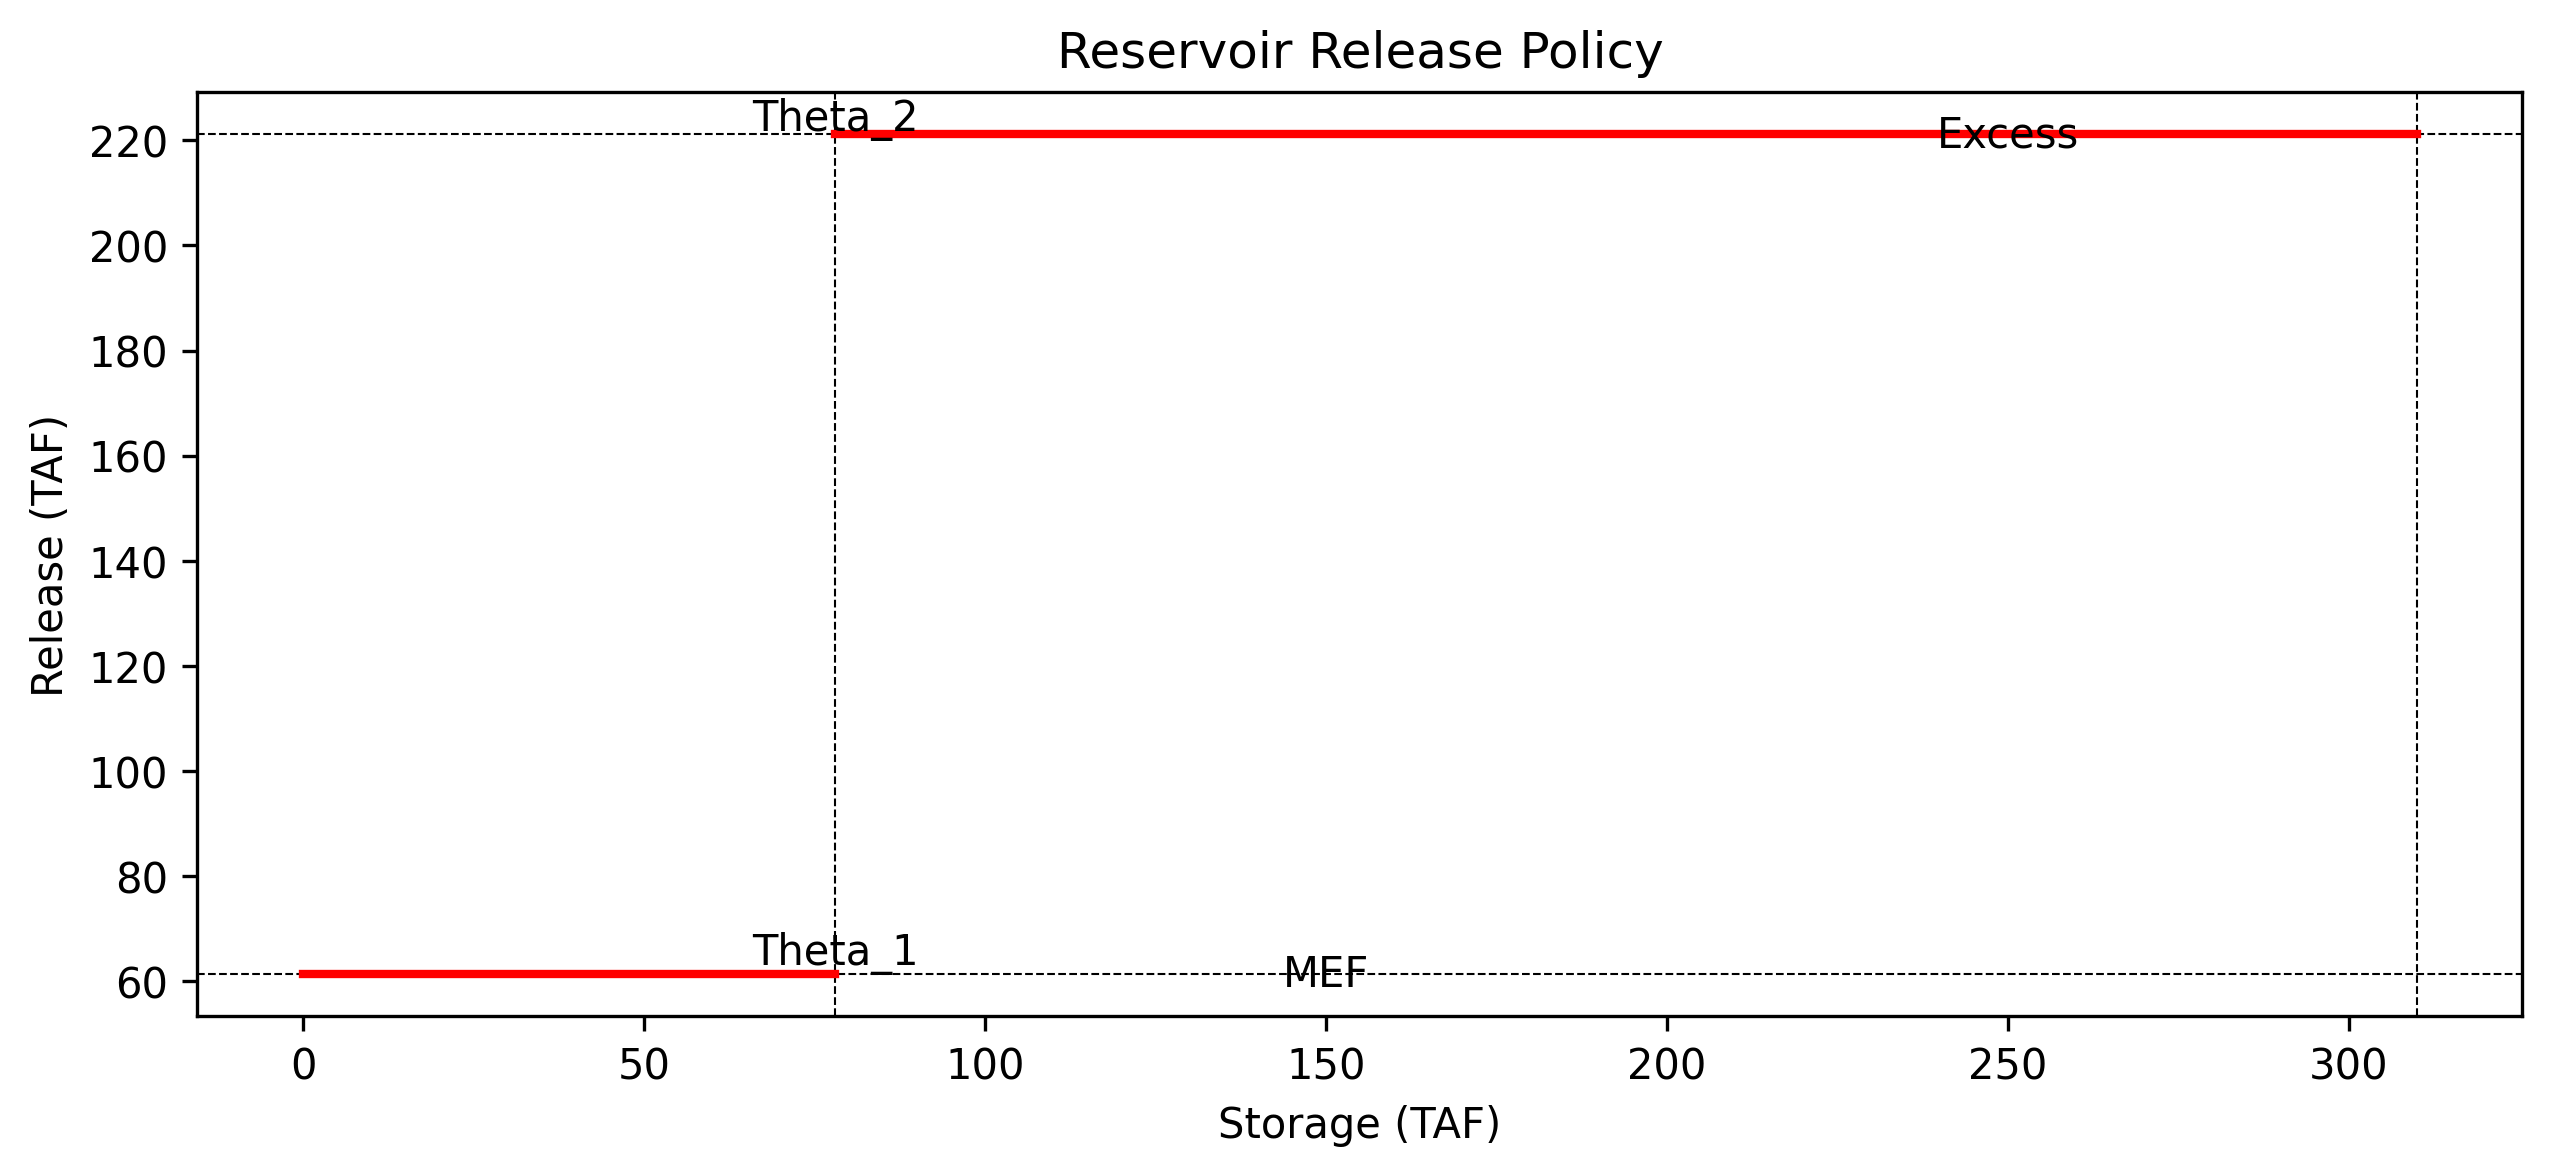

<Figure size 3000x1200 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
#Define parameters and constants
sim_step = 60*60*24
cfs_to_taf= 2.29568411*10**-5
Inflow_tafd= inflow_monthly.values*cfs_to_taf


S= 352.577 #TAF, reservoir max capacity
MEF = 61.322 #TAF
Excess = 221.182 #TAF


Theta_1 = 78 #TAF
Theta_2 = 310 #TAF
# Define storage values (x-axis)
#storage_values = np.linspace(0, 352.577, 100)  # Storage from 0 to max capacity

storage_points =[0, Theta_1, Theta_2, 352.577]
release_points = [MEF, Excess] # Changed MFE to MEF
hor_storage = [storage_points[0], Theta_1, Theta_2, 352.577]
hor_release = [MEF, Excess] # hor_release has two elements corresponding to two segments
plt.plot(figsize=(8,4))
plt.axhline(y=MEF, color="black", linestyle='--',linewidth=0.5)
plt.axhline(y=Excess, color="black", linestyle='--',linewidth=0.5)
plt.axvline(x=Theta_1, color="black", linestyle='--',linewidth=0.5)
plt.axvline(x=Theta_2, color="black", linestyle='--',linewidth=0.5)

# The loop should iterate over the number of segments, which is one less than the number of storage points.
# We use len(hor_release) because the number of segments is equal to the number of release points.
for i in range(len(hor_release)):
    plt.plot([hor_storage[i], hor_storage[i+1]], [hor_release[i], hor_release[i]], color="red",linewidth=2)

plt.title("Reservoir Release Policy")
plt.xlabel("Storage (TAF)")
plt.ylabel("Release (TAF)")
# Add labels for Theta_1, Theta_2, MEF and Excess
plt.text(78, 61.322, 'Theta_1', ha='center', va='bottom')  # Label for Theta_1
plt.text(78, 220, 'Theta_2', ha='center', va='bottom')  # Label for Theta_2
plt.text(150, 61.322, 'MEF', ha='center', va='center')  # Label for MEF
plt.text(250, 221.182, 'Excess', ha='center', va='center')  # Label for Excess
plt.show()
plt.savefig('Reservoir Release Policy.jpg')




A function to simulate Falls Lake Reservoir according to the formulated assumptions and calculate two indicators: i.e., (A). Flood: Number of flood days: storage > max_storage;  calculated before imposing physical constraints. (B). MEF: Number of days in which release doesn’t meet minimum environmental flow. The function is called as follows: storage, release, flood_indicator, MFE_indicator = simulate(Theta)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas


#Define parameters and constants
cfs_to_taf= 2.29568411*10**-5
Inflow_tafd= inflow['inflow_cfs'].values*cfs_to_taf

# Convert Inflow_tafd to a pandas Series with the date_range as index
Inflow_tafd_series = pd.Series(Inflow_tafd, index=date_range)
Inflow_monthly = Inflow_tafd_series.resample('ME').sum() # monthly values

In [ ]:
print(Inflow_monthly)

2010-10-31    0.103673
2010-11-30    0.071648
2010-12-31    0.130670
2011-01-31    0.104821
2011-02-28    0.206818
                ...   
2022-05-31    0.502158
2022-06-30    0.093503
2022-07-31    0.212374
2022-08-31    0.076125
2022-09-30    0.171556
Freq: ME, Length: 144, dtype: float64


Function to simulate Falls Lake Reservoir according to the assumptions formulated, including calculate two indicators: A. Flood: Number of flood days: storage > max_storage. Calculate this before imposing physical constraints. B. MFE Deficit: Number of days in which release doesn’t meet MFE. The function should be called as follows: storage, release, flood_indicator, MFE_indicator = simulate(Theta)

Optimization function to optimize Theta_1 and Theta_2; Theta = [Theta_1, Theta_2] using the platypus package to return indicators of Flood and MFE Deficit (i.e., maintain MEF and Excess), set lower and upper bound as follows:lb = 0 #lower bound ub = max_storage #upper_bound

In [ ]:
!pip install platypus-opt

In [ ]:
import numpy as np

def simulate(Theta):
    """
    Simulates Falls Lake reservoir operation and calculates flood and MFE indicators.

    Args:
        Theta (list): A list containing two elements: Theta_1 and Theta_2,
                      which are the storage thresholds for the release policy.

    Returns:
        tuple: A tuple containing four elements:
            - storage (np.array): An array of storage values over the simulation period.
            - release (np.array): An array of release values over the simulation period.
            - flood_indicator (int): The number of flood days (storage > max_storage).
            - MFE_indicator (int): The number of days with release < MFE.
    """

    # Constants and assumptions
    max_storage = 352.577  # TAF
    cfs_to_taf= 2.29568411*10**-5*sim_step/1000 # Conversion factor from cubic feet per second to TAF/day
    MEF = 61.322 # Minimum environmental flow (TAF)
    excess = 221.182  # Excess release (TAF)
    # Theta_1 = 78 #TAF   # Remove these lines to use Theta from the argument
    # Theta_2 = 310 #TAF  # Remove these lines to use Theta from the argument
    Theta_1, Theta_2 = Theta  # Storage thresholds for release policy


    # Initialize storage and release arrays
    storage = np.zeros(len(inflow))
    release = np.zeros(len(inflow))

    # Initial storage (assuming starting at full capacity)
    storage[0] = max_storage
    flood_indicator = 0
    deficit_indicator = 0
    # Simulation loop
    # Change the range of the loop to iterate from 1 to len(inflow) -1 to avoid IndexError
    # Previous implementation: for t in range(1, len(inflow)):
    for t in range(len(inflow) -1):
        # Calculate inflow in TAF
        # Assuming Inflow_monthly is a sequence (like a list or array)
        # and you want to use the value corresponding to the current time step
        # Accessing element at t+1 here to avoid the error in the last iteration
        Inflow_tafd = Inflow_monthly[t + 1] # Access the element using index t

        storage[t] = storage[t - 1] + Inflow_tafd
        if storage[t] > max_storage:
            flood_indicator +=1
        storage[t] = min(storage[t], max_storage)

        # Determine release based on storage and Theta values
        if storage[t] < Theta_1:
            release[t] = MEF
        elif storage[t] < Theta_2:
            release[t] = excess # Added release logic for the elif condition
        else:
            release[t] = excess

        # Update storage after release
        storage[t] -= release[t]

    # Calculate indicators
    MFE_indicator = np.sum(release < MEF)

    return storage, release, flood_indicator, MFE_indicator

In [ ]:
!pip install platypus-opt

In [ ]:
def simulate_MOEA(Theta):
  _,_, flood_indicator, deficit_indicator = simulate(Theta)
  return [flood_indicator, deficit_indicator]

from platypus import NSGAII, Problem, Real

# Problem Definition
max_storage = 352.577
problem = Problem(2, 2)  # 2 decision variables, 2 objectives
lb = 0  # Lower bound for Theta_1 and Theta_2
ub = max_storage # Upper bound for Theta_1 and Theta_2

problem.types[0] = Real(lb, ub)  # Theta_1 bounds
problem.types[1] = Real(lb, ub)  # Theta_2 bounds
problem.function = simulate_MOEA

# Optimization Algorithm
algorithm = NSGAII(problem)

# Optimize the problem using max_NFE function evaluations
max_NFE = 1000
algorithm.run(max_NFE)

results = algorithm.result

# Convert results to numpy arrays
J = np.array([s.objectives for s in algorithm.result])
theta_sol = np.array([s.variables for s in algorithm.result])

# Plot Pareto Front
plt.figure(figsize=(8, 3))
plt.scatter(J[:,0],J[:,1],label='Pareto Front')
plt.xlabel("Flood months")
plt.ylabel("MFE deficit months")
plt.title("Pareto Front of Flood Months and MFE Deficit @ 1000 NFE")
plt.scatter(flood_indicator, deficit_indicator, marker='x',color='red',label='Q1 Policy')
plt.legend()
plt.show()

<ipython-input-72-4d235eae4784>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Inflow_tafd = Inflow_monthly[t + 1] # Access the element using index t


IndexError: index 144 is out of bounds for axis 0 with size 144